<a href="https://colab.research.google.com/github/wastb/Time-Forecasting/blob/master/notebooks/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Objective***

*The aim of this notebook is to analyze the risk-return profile of the portfolio using performance metrics such as the Sharpe Ratio and Value at Risk (VaR) and provide an optimized approach to maximize return*

In [ ]:
!pip install PyPortfolioOpt

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Import Libraries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [2]:
#Read predicted data
predicted_tsla = pd.read_csv('/content/drive/MyDrive/predictions_tsla.csv')
predicted_spy = pd.read_csv('/content/drive/MyDrive/predictions_sp.csv')
predicted_bnd = pd.read_csv('/content/drive/MyDrive/predictions_bnd.csv')

In [3]:
#Rename the Unnamed column
predicted_tsla.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
predicted_spy.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
predicted_bnd.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)

In [4]:
#Rename the adj close column with the respective ticker symbol
predicted_tsla.rename(columns = {'Adj Close':'TSLA'}, inplace = True)
predicted_spy.rename(columns = {'Adj Close':'SPY'}, inplace = True)
predicted_bnd.rename(columns = {'Adj Close':'BND'}, inplace = True)

In [5]:
#Check data
print('==========================================================================')
print(predicted_tsla.head())
print('==========================================================================')
print(predicted_spy.head())
print('==========================================================================')
print(predicted_bnd.head())
print('==========================================================================')

         Date       TSLA
0  2025-01-31  406.85754
1  2025-02-01  404.89883
2  2025-02-02  403.93860
3  2025-02-03  403.52783
4  2025-02-04  403.42530
         Date        SPY
0  2025-01-31  577.46173
1  2025-02-01  577.06220
2  2025-02-02  575.69020
3  2025-02-03  573.68020
4  2025-02-04  571.25586
         Date       BND
0  2025-01-31  78.77985
1  2025-02-01  78.82189
2  2025-02-02  78.86776
3  2025-02-03  78.91584
4  2025-02-04  78.96515


In [6]:
#Merge the data into a single dataframe
merged_df = pd.merge(predicted_tsla, predicted_spy, on='Date')
merged_df = pd.merge(merged_df, predicted_bnd, on='Date')
merged_df.head()

,Date,TSLA,SPY,BND
0,2025-01-31,406.85754,577.46173,78.77985
1,2025-02-01,404.89883,577.06220,78.82189
2,2025-02-02,403.93860,575.69020,78.86776
3,2025-02-03,403.52783,573.68020,78.91584
4,2025-02-04,403.42530,571.25586,78.96515


In [7]:
#Change the date column into datetime and set it as index
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)
merged_df.head()

,TSLA,SPY,BND
Date,,,
2025-01-31,406.85754,577.46173,78.77985
2025-02-01,404.89883,577.06220,78.82189
2025-02-02,403.93860,575.69020,78.86776
2025-02-03,403.52783,573.68020,78.91584
2025-02-04,403.42530,571.25586,78.96515


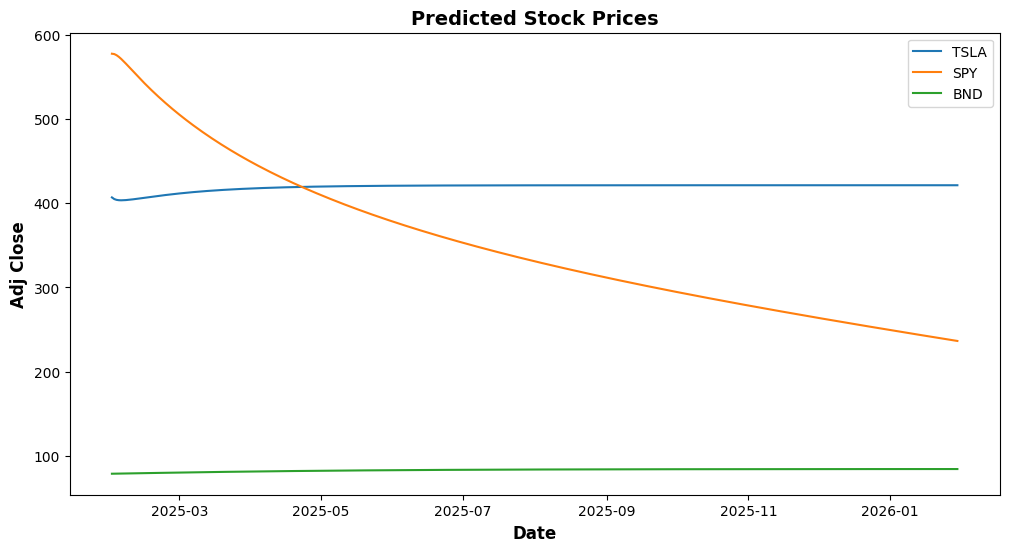

In [8]:
#Plot the merged data for all three tickers
plt.figure(figsize=(12, 6))
plt.plot(merged_df['TSLA'], label='TSLA')
plt.plot(merged_df['SPY'], label='SPY')
plt.plot(merged_df['BND'], label='BND')
plt.title('Predicted Stock Prices',fontsize=14, fontweight='bold')
plt.xlabel('Date',fontsize=12, fontweight='bold')
plt.ylabel('Adj Close',fontsize=12, fontweight='bold')
plt.legend()
plt.show()

# ***Optimization***

In [9]:
# Calculate daily returns
df_return = merged_df.pct_change().dropna()
df_return.head()

,TSLA,SPY,BND
Date,,,
2025-02-01,-0.004814,-0.000692,0.000534
2025-02-02,-0.002372,-0.002378,0.000582
2025-02-03,-0.001017,-0.003491,0.000610
2025-02-04,-0.000254,-0.004226,0.000625
2025-02-05,0.000187,-0.004700,0.000632


In [10]:
# Compute covariance matrix
cov_matrix = df_return.cov()
print("Covariance Matrix:\n", cov_matrix)

Covariance Matrix:
               TSLA           SPY           BND
TSLA  1.417973e-07 -2.212657e-07  2.978547e-08
SPY  -2.212657e-07  8.369644e-07 -1.671056e-07
BND   2.978547e-08 -1.671056e-07  3.718180e-08


In [11]:
# Define the number of equities
num_equities = 3
# Calculate equal weights
equal_weights = np.full(num_equities, 1 / num_equities)
# Compute portfolio variance
portfolio_variance = np.dot(equal_weights.T, np.dot(cov_matrix * 252, equal_weights))
print(f"Portfolio Variance: {portfolio_variance:.6f}")

Portfolio Variance: 0.000008


In [12]:
# Compute portfolio risk (volatility)
portfolio_volatility = np.sqrt(portfolio_variance)
print(f"Portfolio Volatility (Risk): {portfolio_volatility:.4f}")

Portfolio Volatility (Risk): 0.0029


In [13]:
# Compute annualized mean returns for each asset
annual_returns = np.sum((df_return.mean()*equal_weights)*252)
print("Annualized Mean Returns:\n", annual_returns)

Annualized Mean Returns:
 -0.18202207167568155


In [14]:
#Visulaize the Expected Annual Return, Volatility(Risk) and Variance
print(f"Expected Annual Return: {annual_returns:.2%}")
print(f"Portfolio Volatility (Risk): {portfolio_volatility:.2%}")

Expected Annual Return: -18.20%
Portfolio Volatility (Risk): 0.29%


In [19]:
# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(merged_df)  # Annualized returns
cov_matrix = risk_models.sample_cov(merged_df)  # Annualized covariance

# Generate random portfolios
num_portfolios = 10000
assets = merged_df.columns
n_assets = len(assets)

np.random.seed(42)
weights = np.random.dirichlet(np.ones(n_assets), num_portfolios)
returns = np.dot(weights, mu)
stddevs = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))
sharpe_ratios = returns / stddevs  # Assuming risk-free rate = 0

# Find min volatility and max Sharpe portfolios
min_vol_idx = np.argmin(stddevs)
max_sharpe_idx = np.argmax(sharpe_ratios)

# Random portfolios results
random_portfolios = [
    {'weights': w, 'return': r, 'stddev': s, 'sharpe': sr}
    for w, r, s, sr in zip(weights, returns, stddevs, sharpe_ratios)
]

# Use PyPortfolioOpt to get EXACT optimal portfolios

# Minimum Volatility Portfolio
ef_minvol = EfficientFrontier(mu, cov_matrix)
ef_minvol.min_volatility()
min_vol_weights = ef_minvol.clean_weights()
min_vol_return, min_vol_stddev, _ = ef_minvol.portfolio_performance()

# Maximum Sharpe Portfolio
ef_maxsharpe = EfficientFrontier(mu, cov_matrix)
ef_maxsharpe.max_sharpe()
max_sharpe_weights = ef_maxsharpe.clean_weights()
max_sharpe_return, max_sharpe_stddev, _ = ef_maxsharpe.portfolio_performance()

# Compile results into a dictionary
ef_results = {
    'random_portfolios': random_portfolios,
    'min_vol': {
        'weights': np.array([min_vol_weights[asset] for asset in assets]),
        'return': min_vol_return,
        'stddev': min_vol_stddev,
    },
    'max_sharpe': {
        'weights': np.array([max_sharpe_weights[asset] for asset in assets]),
        'return': max_sharpe_return,
        'stddev': max_sharpe_stddev,
    }
}

<ipython-input-20-f449f806e8fe>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  asset_ret = mu[i]



Minimum Volatility Portfolio:
Expected Return: -4.35%
Expected Volatility: 0.04%
Sharpe Ratio: -107.20
Asset Allocation:
TSLA: 13.01%
SPY: 17.41%
BND: 69.58%

Maximum Sharpe Ratio Portfolio:
Expected Return: 4.83%
Expected Volatility: 0.31%
Sharpe Ratio: 15.78
Asset Allocation:
TSLA: 0.00%
SPY: 0.00%
BND: 100.00%


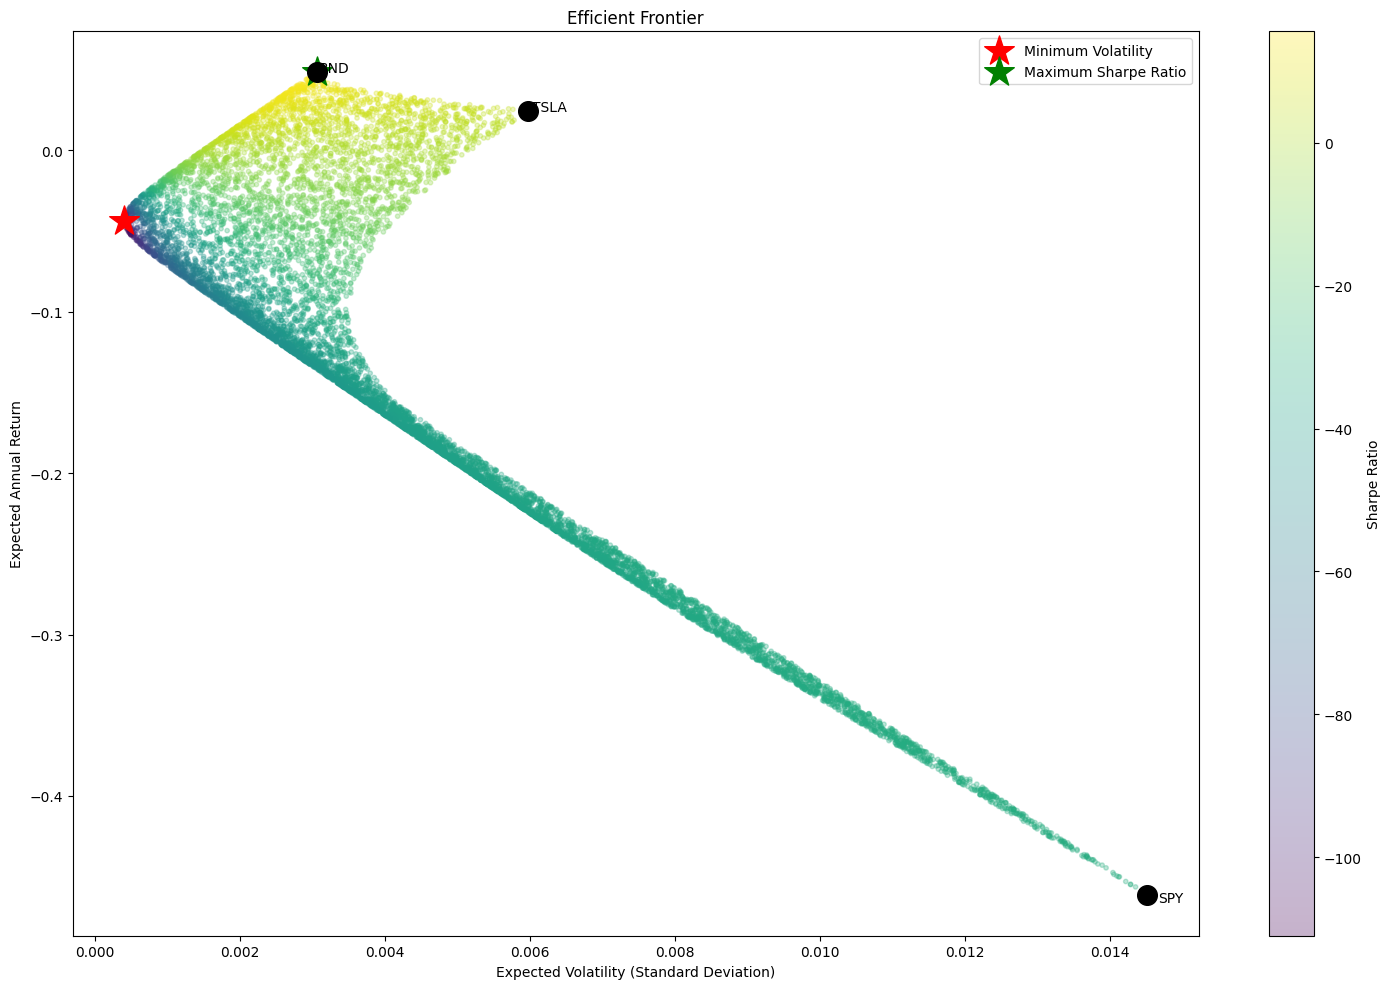

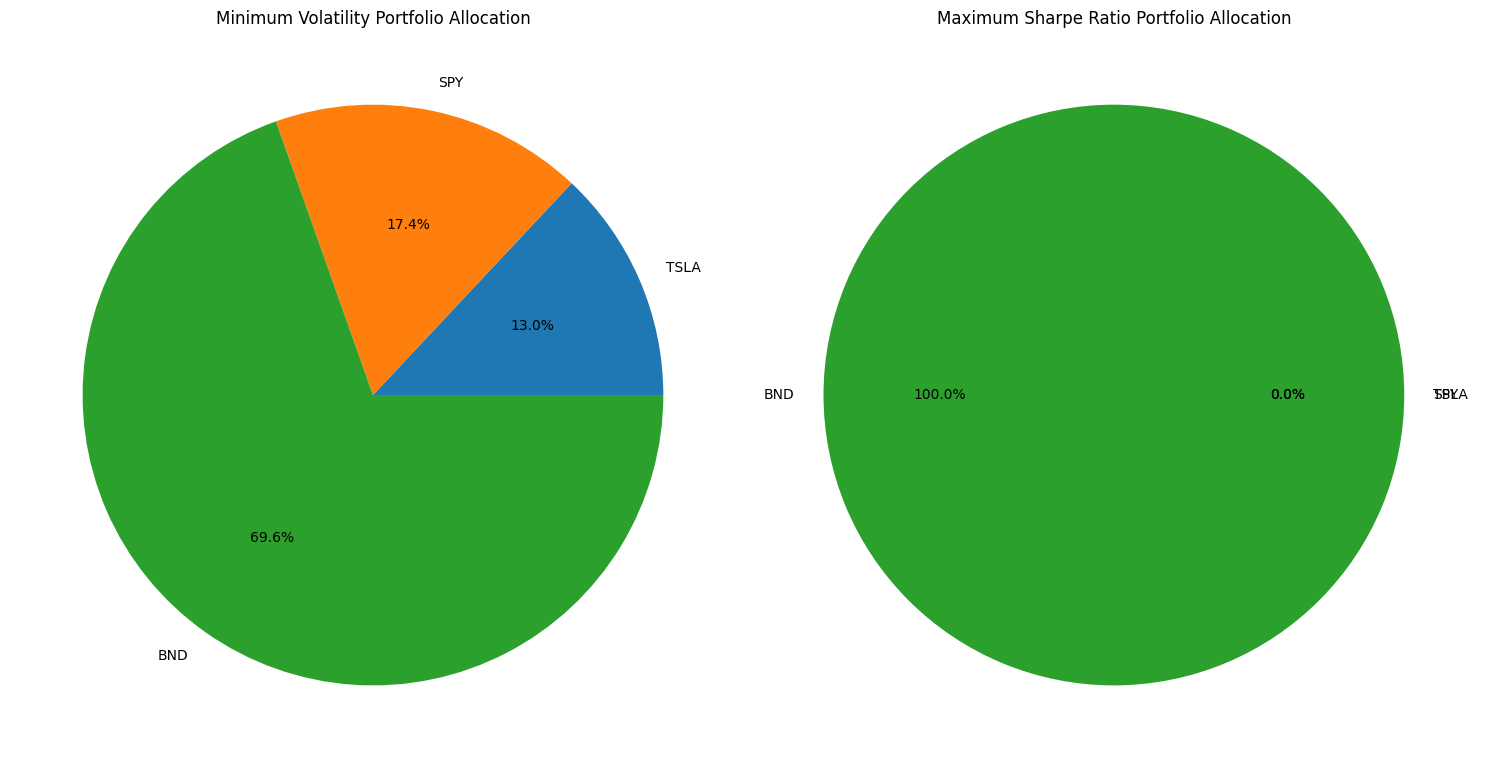

In [20]:
# Plot Efficient Frontier
plt.figure(figsize=(15, 10))
returns = [p['return'] for p in ef_results['random_portfolios']]
stddevs = [p['stddev'] for p in ef_results['random_portfolios']]

plt.scatter(stddevs, returns, c=np.array(returns)/np.array(stddevs),
            marker='o', cmap='viridis', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Plot optimal portfolios
plt.scatter(ef_results['min_vol']['stddev'], ef_results['min_vol']['return'],
            marker='*', color='r', s=500, label='Minimum Volatility')
plt.scatter(ef_results['max_sharpe']['stddev'], ef_results['max_sharpe']['return'],
            marker='*', color='g', s=500, label='Maximum Sharpe Ratio')

# Plot individual assets
for i, asset in enumerate(assets):
    asset_vol = np.sqrt(cov_matrix.iloc[i, i])
    asset_ret = mu[i]
    plt.scatter(asset_vol, asset_ret, marker='o', s=200, color='black')
    plt.annotate(asset, (asset_vol*1.01, asset_ret*1.01))

plt.title('Efficient Frontier')
plt.xlabel('Expected Volatility (Standard Deviation)')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.tight_layout()

# Print Portfolio Weights & Metrics
print("\nMinimum Volatility Portfolio:")
print("Expected Return: {:.2%}".format(ef_results['min_vol']['return']))
print("Expected Volatility: {:.2%}".format(ef_results['min_vol']['stddev']))
print("Sharpe Ratio: {:.2f}".format(ef_results['min_vol']['return']/ef_results['min_vol']['stddev']))
print("Asset Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {ef_results['min_vol']['weights'][i]:.2%}")

print("\nMaximum Sharpe Ratio Portfolio:")
print("Expected Return: {:.2%}".format(ef_results['max_sharpe']['return']))
print("Expected Volatility: {:.2%}".format(ef_results['max_sharpe']['stddev']))
print("Sharpe Ratio: {:.2f}".format(ef_results['max_sharpe']['return']/ef_results['max_sharpe']['stddev']))
print("Asset Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {ef_results['max_sharpe']['weights'][i]:.2%}")

# Plot Asset Allocations
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.pie(ef_results['min_vol']['weights'], labels=assets, autopct='%1.1f%%')
plt.title('Minimum Volatility Portfolio Allocation')

plt.subplot(1, 2, 2)
plt.pie(ef_results['max_sharpe']['weights'], labels=assets, autopct='%1.1f%%')
plt.title('Maximum Sharpe Ratio Portfolio Allocation')

plt.tight_layout()
plt.show()